In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder

# Load the dataset (replace 'file_path' with the actual path to your dataset)
df = pd.read_csv('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

# Step 1: Drop Non-Useful Columns
# Drop UDI and Product ID as they are identifiers
df = df.drop(['UDI', 'Product ID'], axis=1)

# Step 2: Identify Label Column and Separate Features and Labels
# Target column: 'Failure Type'
X = df.drop(['Failure Type'], axis=1)  # Features
y = df['Failure Type']  # Labels

# Step 3: Convert Categorical Data
# Encoding 'Type' column using One-Hot Encoding
X = pd.get_dummies(X, columns=['Type'], drop_first=True)

# Step 4: Standardization/Normalization
# Standardize continuous columns
scaler = StandardScaler()
continuous_columns = ['Air temperature [K]', 'Process temperature [K]', 
                      'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']
X[continuous_columns] = scaler.fit_transform(X[continuous_columns])

# Step 5: Label Encoding for the Target (if needed)
# Converting 'Failure Type' to numerical labels for multi-class classification
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Print a summary of the processed data
print("Processed feature set (X):")
print(X.head())
print("\nEncoded labels (y):", y[:5])


Processed feature set (X):
   Air temperature [K]  Process temperature [K]  Rotational speed [rpm]  \
0            -0.952389                -0.947360                0.068185   
1            -0.902393                -0.879959               -0.729472   
2            -0.952389                -1.014761               -0.227450   
3            -0.902393                -0.947360               -0.590021   
4            -0.902393                -0.879959               -0.729472   

   Torque [Nm]  Tool wear [min]  Target  Type_L  Type_M  
0     0.282200        -1.695984       0   False    True  
1     0.633308        -1.648852       0    True   False  
2     0.944290        -1.617430       0    True   False  
3    -0.048845        -1.586009       0    True   False  
4     0.001313        -1.554588       0    True   False  

Encoded labels (y): [1 1 1 1 1]


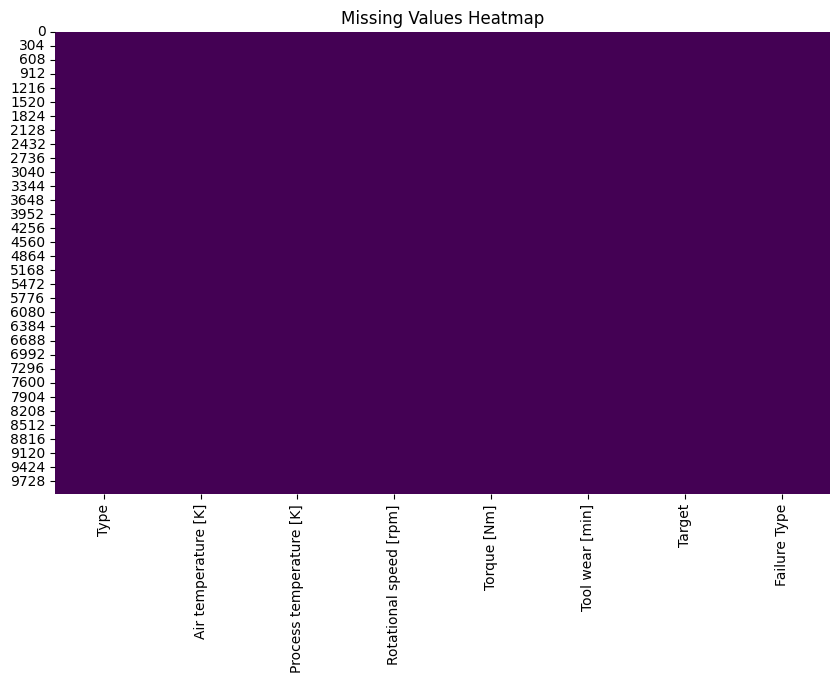

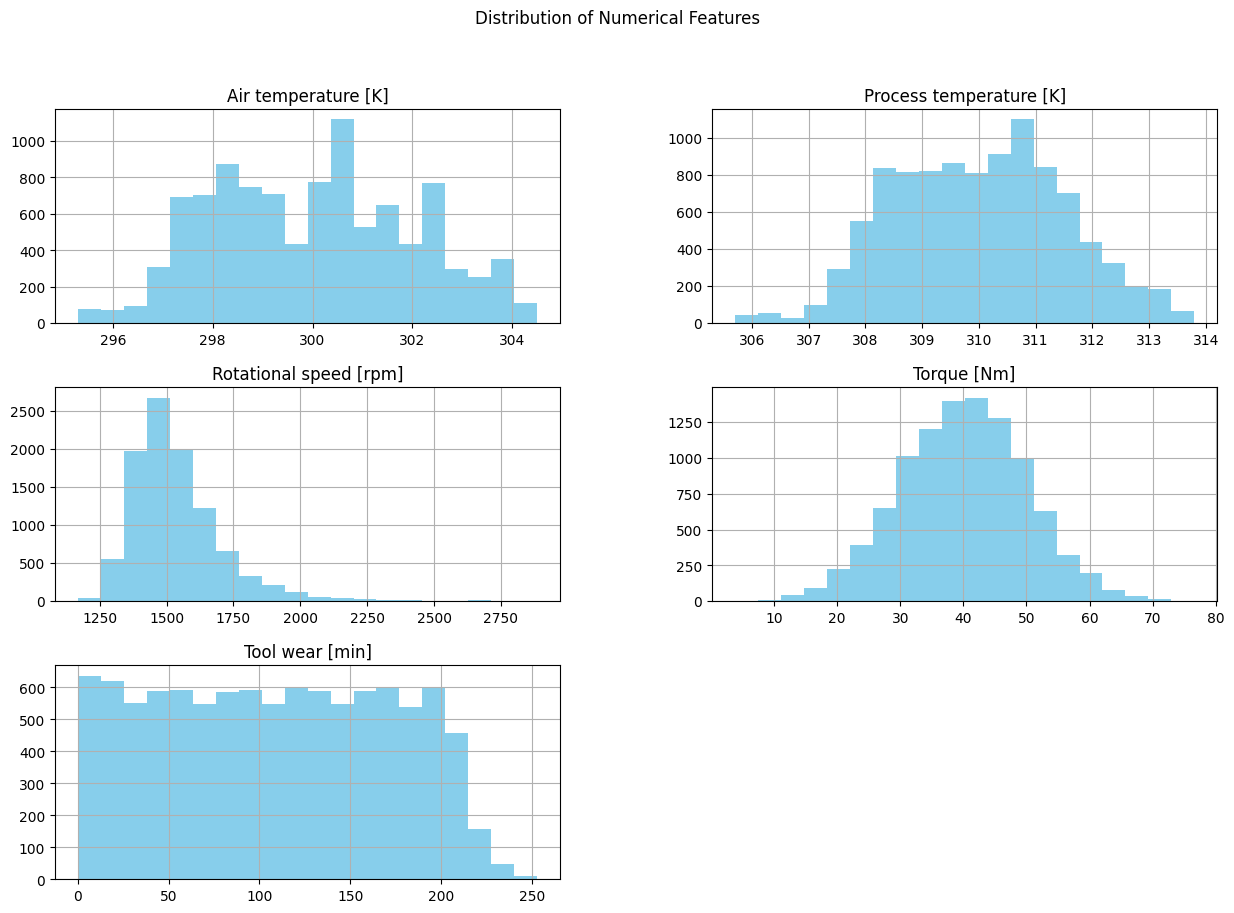

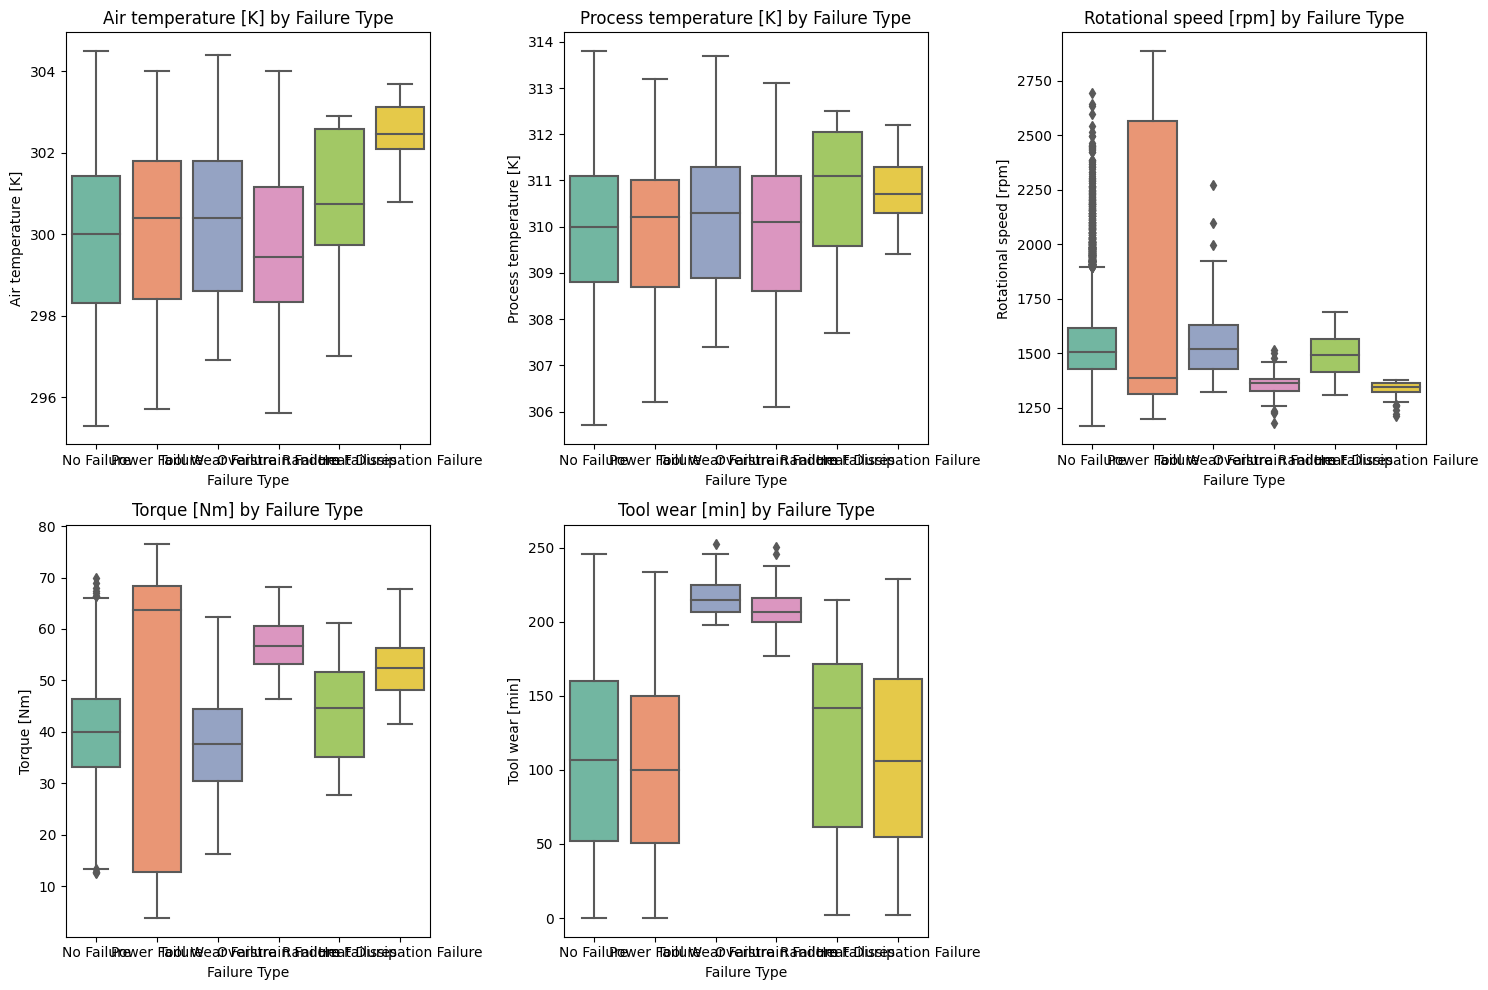

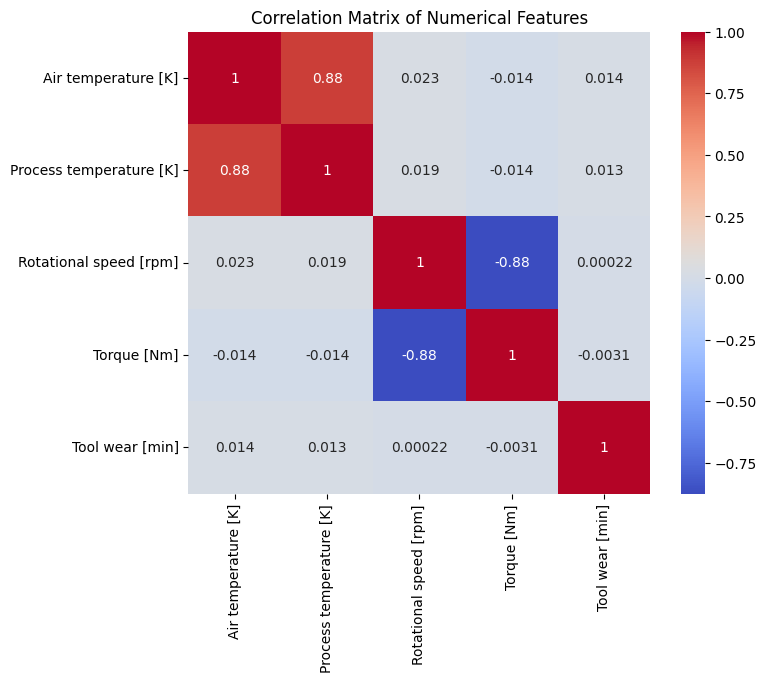

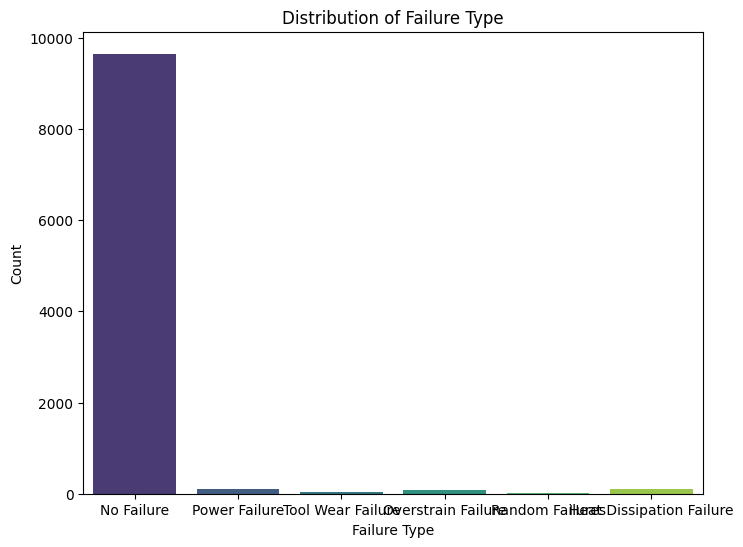

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Check for Missing Values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

# Step 2: Data Distribution Analysis
# Plot histograms for numerical columns
numerical_columns = ['Air temperature [K]', 'Process temperature [K]', 
                     'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

df[numerical_columns].hist(bins=20, figsize=(15, 10), color='skyblue')
plt.suptitle('Distribution of Numerical Features')
plt.show()

# Box plots to visualize distribution and potential outliers
plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_columns, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df, x='Failure Type', y=col, palette="Set2")
    plt.title(f'{col} by Failure Type')
plt.tight_layout()
plt.show()

# Step 3: Correlation Analysis
# Calculate correlation matrix
corr_matrix = df[numerical_columns].corr()

# Plot heatmap of correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title('Correlation Matrix of Numerical Features')
plt.show()

# Step 4: Visualize Target Distribution
# Plot the distribution of Failure Type
plt.figure(figsize=(8, 6))
sns.countplot(data=df, x='Failure Type', palette='viridis')
plt.title('Distribution of Failure Type')
plt.xlabel('Failure Type')
plt.ylabel('Count')
plt.show()

In [4]:
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from collections import Counter

# Load the dataset
df = pd.read_csv('/kaggle/input/machine-predictive-maintenance-classification/predictive_maintenance.csv')

# Preprocessing from Step 1
df = df.drop(['UDI', 'Product ID'], axis=1)  # Drop non-informative columns
X = df.drop(['Failure Type'], axis=1)  # Features
y = df['Failure Type']  # Labels

# Encode categorical features and label
X = pd.get_dummies(X, columns=['Type'], drop_first=True)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)  # Encode labels

# Check class distribution
print("Original class distribution:", Counter(y))

# Split the data into training and test sets before applying SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training data to handle class imbalance
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Check new class distribution after SMOTE
print("Class distribution after SMOTE:", Counter(y_train_smote))

# Standardize the numerical features in the training and test sets
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_test = scaler.transform(X_test)

# Convert back to Pandas DataFrame if needed (PyTorch can work with numpy arrays directly)
X_train_smote = pd.DataFrame(X_train_smote, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

# (Optional) Save class weights for PyTorch model
import torch
import numpy as np

# Calculate class weights inversely proportional to class frequencies
class_counts = Counter(y_train_smote)
total_samples = sum(class_counts.values())
class_weights = {label: total_samples / count for label, count in class_counts.items()}

# Convert to tensor for use in PyTorch's CrossEntropyLoss
class_weights_tensor = torch.tensor(list(class_weights.values()), dtype=torch.float32)

print("Class weights for PyTorch:", class_weights_tensor)


Original class distribution: Counter({1: 9652, 0: 112, 3: 95, 2: 78, 5: 45, 4: 18})
Class distribution after SMOTE: Counter({1: 7717, 3: 7717, 0: 7717, 5: 7717, 2: 7717, 4: 7717})
Class weights for PyTorch: tensor([6., 6., 6., 6., 6., 6.])


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the neural network architecture
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)  # First hidden layer
        self.fc2 = nn.Linear(64, 64)  # Second hidden layer
        self.fc3 = nn.Linear(64, 64)  # Third hidden layer
        self.output = nn.Linear(64, num_classes)  # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)  # Output layer (logits)
        return x

# Parameters
input_size = X_train_smote.shape[1]  # Number of features after encoding
num_classes = len(label_encoder.classes_)  # Number of unique classes in Failure Type

# Initialize model, loss function, and optimizer
model = MLPClassifier(input_size, num_classes)
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)  # Using class weights for imbalance
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Example for training loop setup (adjust epochs as needed)
num_epochs = 20
batch_size = 32

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_smote.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Training loop
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    optimizer.zero_grad()  # Clear gradients

    # Forward pass
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

# Example testing (to be expanded with metrics in later steps)
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    _, predicted = torch.max(test_outputs, 1)
    accuracy = (predicted == y_test_tensor).sum().item() / len(y_test_tensor)
    print(f'Test Accuracy: {accuracy:.4f}')


Epoch [5/20], Loss: 1.7613
Epoch [10/20], Loss: 1.7188
Epoch [15/20], Loss: 1.6640
Epoch [20/20], Loss: 1.5880
Test Accuracy: 0.9625


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import math

# Define the neural network model
class MLPClassifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 64)
        self.output = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.output(x)
        return x

# Hyperparameter grid
learning_rates = [0.001, 0.01, 0.1]
optimizers = ['SGD', 'Adam', 'RMSprop']
epochs_list = [50, 100, 200]

# Store the best model, parameters, and validation loss
best_model = None
best_params = None
best_val_loss = float('inf')

# Split the training data into training and validation sets
X_train_smote, X_val, y_train_smote, y_val = train_test_split(
    X_train_smote, y_train_smote, test_size=0.2, random_state=42
)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_smote.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_smote, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Loop through all combinations of hyperparameters
for lr in learning_rates:
    for optimizer_name in optimizers:
        for epochs in epochs_list:
            # Initialize the model
            model = MLPClassifier(input_size=X_train_tensor.shape[1], num_classes=len(label_encoder.classes_))
            loss_fn = nn.CrossEntropyLoss()  # CrossEntropyLoss for multi-class classification

            # Select optimizer
            if optimizer_name == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=lr)
            elif optimizer_name == 'Adam':
                optimizer = optim.Adam(model.parameters(), lr=lr)
            elif optimizer_name == 'RMSprop':
                optimizer = optim.RMSprop(model.parameters(), lr=lr)
            
            # Training the model
            for epoch in range(epochs):
                model.train()
                optimizer.zero_grad()
                y_pred = model(X_train_tensor)
                loss = loss_fn(y_pred, y_train_tensor)
                loss.backward()
                optimizer.step()

            # Validation loss after training
            model.eval()
            with torch.no_grad():
                val_pred = model(X_val_tensor)
                val_loss = loss_fn(val_pred, y_val_tensor)
            
            # Save the best model based on validation loss
            if val_loss.item() < best_val_loss:
                best_val_loss = val_loss.item()
                best_model = model
                best_params = {'learning_rate': lr, 'optimizer': optimizer_name, 'epochs': epochs}

            print(f"LR: {lr}, Optimizer: {optimizer_name}, Epochs: {epochs}, Val Loss: {val_loss.item():.4f}")

# Test the best model
best_model.eval()
with torch.no_grad():
    y_test_pred = best_model(X_test_tensor)
    test_loss = loss_fn(y_test_pred, y_test_tensor)
    
print(f'Test Loss for Best Model: {test_loss.item():.4f}')
print(f'Best Hyperparameters: {best_params}')

# Calculate additional metrics
y_test_pred_np = y_test_pred.argmax(dim=1).numpy()
y_test_np = y_test_tensor.numpy()

mse = mean_squared_error(y_test_np, y_test_pred_np)
rmse = math.sqrt(mse)
mae = mean_absolute_error(y_test_np, y_test_pred_np)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.4f}')


LR: 0.001, Optimizer: SGD, Epochs: 50, Val Loss: 1.7902
LR: 0.001, Optimizer: SGD, Epochs: 100, Val Loss: 1.7916
LR: 0.001, Optimizer: SGD, Epochs: 200, Val Loss: 1.7993
LR: 0.001, Optimizer: Adam, Epochs: 50, Val Loss: 0.7145
LR: 0.001, Optimizer: Adam, Epochs: 100, Val Loss: 0.2411
LR: 0.001, Optimizer: Adam, Epochs: 200, Val Loss: 0.1028
LR: 0.001, Optimizer: RMSprop, Epochs: 50, Val Loss: 0.2210
LR: 0.001, Optimizer: RMSprop, Epochs: 100, Val Loss: 0.1565
LR: 0.001, Optimizer: RMSprop, Epochs: 200, Val Loss: 0.1071
LR: 0.01, Optimizer: SGD, Epochs: 50, Val Loss: 1.7775
LR: 0.01, Optimizer: SGD, Epochs: 100, Val Loss: 1.7684
LR: 0.01, Optimizer: SGD, Epochs: 200, Val Loss: 1.7523
LR: 0.01, Optimizer: Adam, Epochs: 50, Val Loss: 0.0928
LR: 0.01, Optimizer: Adam, Epochs: 100, Val Loss: 0.0534
LR: 0.01, Optimizer: Adam, Epochs: 200, Val Loss: 0.0147
LR: 0.01, Optimizer: RMSprop, Epochs: 50, Val Loss: 0.1373
LR: 0.01, Optimizer: RMSprop, Epochs: 100, Val Loss: 0.0892
LR: 0.01, Optimizer

Epoch [10/200], Train Loss: 0.6574, Validation Loss: 0.6698, Train Acc: 0.6896, Val Acc: 0.7241
Epoch [20/200], Train Loss: 1.8129, Validation Loss: 1.0980, Train Acc: 0.5155, Val Acc: 0.6320
Epoch [30/200], Train Loss: 0.7440, Validation Loss: 0.7807, Train Acc: 0.6461, Val Acc: 0.6620
Epoch [40/200], Train Loss: 0.7093, Validation Loss: 0.7221, Train Acc: 0.6601, Val Acc: 0.6787
Epoch [50/200], Train Loss: 0.7356, Validation Loss: 0.6869, Train Acc: 0.6368, Val Acc: 0.6901
Epoch [60/200], Train Loss: 0.7793, Validation Loss: 0.7990, Train Acc: 0.6292, Val Acc: 0.6708
Epoch [70/200], Train Loss: 0.7010, Validation Loss: 0.9807, Train Acc: 0.6749, Val Acc: 0.6368
Epoch [80/200], Train Loss: 0.8666, Validation Loss: 0.7471, Train Acc: 0.6697, Val Acc: 0.6901
Epoch [90/200], Train Loss: 0.5935, Validation Loss: 0.5695, Train Acc: 0.7260, Val Acc: 0.7270
Epoch [100/200], Train Loss: 0.6778, Validation Loss: 0.7116, Train Acc: 0.6991, Val Acc: 0.6707
Epoch [110/200], Train Loss: 0.5749, Va

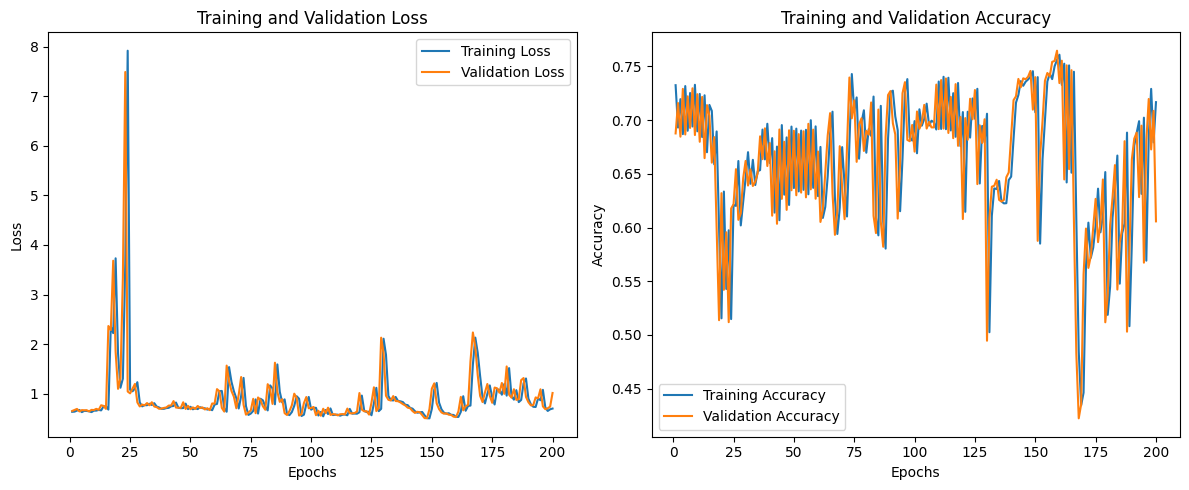

In [10]:
import matplotlib.pyplot as plt

# Initialize lists to store loss and accuracy for each epoch
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training loop with metrics tracking
for epoch in range(best_params['epochs']):
    model.train()
    optimizer.zero_grad()

    # Forward pass
    y_train_pred = model(X_train_tensor)
    train_loss = loss_fn(y_train_pred, y_train_tensor)
    train_losses.append(train_loss.item())

    # Calculate training accuracy
    _, train_pred_labels = torch.max(y_train_pred, 1)
    train_accuracy = (train_pred_labels == y_train_tensor).float().mean().item()
    train_accuracies.append(train_accuracy)

    # Backward pass and optimization
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        y_val_pred = model(X_val_tensor)
        val_loss = loss_fn(y_val_pred, y_val_tensor)
        val_losses.append(val_loss.item())

        # Calculate validation accuracy
        _, val_pred_labels = torch.max(y_val_pred, 1)
        val_accuracy = (val_pred_labels == y_val_tensor).float().mean().item()
        val_accuracies.append(val_accuracy)

    # Print epoch results
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{best_params['epochs']}], Train Loss: {train_loss.item():.4f}, "
              f"Validation Loss: {val_loss.item():.4f}, Train Acc: {train_accuracy:.4f}, Val Acc: {val_accuracy:.4f}")

# Plotting the results
epochs_range = range(1, best_params['epochs'] + 1)

# Loss Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Training Loss')
plt.plot(epochs_range, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Accuracy Plot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Training Accuracy')
plt.plot(epochs_range, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


Classification Report on Training Data:
               precision    recall  f1-score   support

     Class 0       0.43      0.98      0.60      6206
     Class 1       0.45      0.73      0.55      6150
     Class 2       0.98      0.69      0.81      6161
     Class 3       0.79      0.46      0.58      6193
     Class 4       0.99      0.02      0.04      6176
     Class 5       0.96      0.78      0.86      6155

    accuracy                           0.61     37041
   macro avg       0.77      0.61      0.57     37041
weighted avg       0.77      0.61      0.57     37041

Confusion Matrix on Training Data:
 [[6057    2    2   16    0  129]
 [1566 4496    0   85    1    2]
 [1348    0 4240  542    0   31]
 [3232    1   96 2843    0   21]
 [ 479 5570    0    5  122    0]
 [1270    0    3  100    0 4782]]


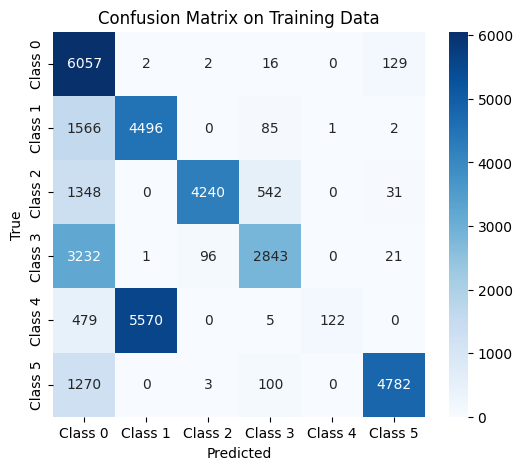

Classification Report on Test Data:
               precision    recall  f1-score   support

     Class 0       0.03      0.93      0.05        15
     Class 1       0.99      0.73      0.85      1935
     Class 2       0.88      0.54      0.67        13
     Class 3       0.18      0.30      0.23        20
     Class 4       0.00      0.00      0.00         6
     Class 5       0.86      0.55      0.67        11

    accuracy                           0.73      2000
   macro avg       0.49      0.51      0.41      2000
weighted avg       0.97      0.73      0.83      2000

Confusion Matrix on Test Data:
 [[  14    0    0    1    0    0]
 [ 487 1422    0   24    1    1]
 [   4    0    7    2    0    0]
 [  11    2    1    6    0    0]
 [   0    6    0    0    0    0]
 [   5    0    0    0    0    6]]


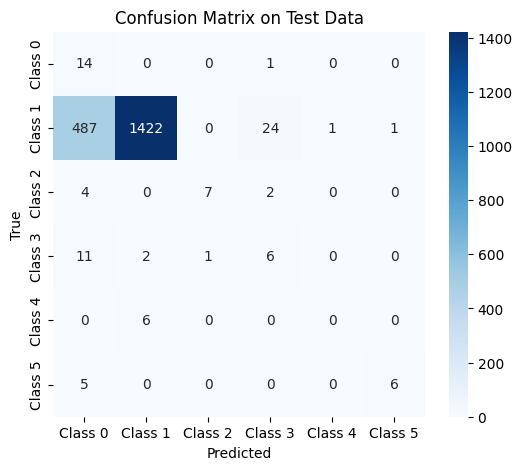

In [12]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Function to evaluate the model on the given data
def evaluate_model(model, X_data, y_data, data_name="Test"):
    # Predict on the data
    model.eval()
    with torch.no_grad():
        y_pred = model(X_data)
        _, predicted_labels = torch.max(y_pred, 1)
    
    # Convert predictions and true labels to numpy arrays for scikit-learn
    predicted_labels = predicted_labels.cpu().numpy()
    y_data = y_data.cpu().numpy()

    # Get the classification report (accuracy, precision, recall, f1-score)
    # Dynamically handle the number of classes based on the target labels
    num_classes = len(np.unique(y_data))
    class_names = [f'Class {i}' for i in range(num_classes)]
    
    report = classification_report(y_data, predicted_labels, target_names=class_names)
    print(f"Classification Report on {data_name} Data:\n", report)
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_data, predicted_labels)
    print(f"Confusion Matrix on {data_name} Data:\n", cm)
    
    # Plot confusion matrix heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title(f'Confusion Matrix on {data_name} Data')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Evaluate on Training Data
evaluate_model(model, X_train_tensor, y_train_tensor, data_name="Training")

# Evaluate on Test Data
evaluate_model(model, X_test_tensor, y_test_tensor, data_name="Test")


Epoch 1/200, Loss: 1.8136
Epoch 51/200, Loss: 1.1602
Epoch 101/200, Loss: 1.1250
Epoch 151/200, Loss: 1.1080
Classification Report on Test with Regularization Data:
               precision    recall  f1-score   support

     Class 0       0.94      1.00      0.97        15
     Class 1       1.00      0.89      0.94      1935
     Class 2       0.87      1.00      0.93        13
     Class 3       0.95      0.95      0.95        20
     Class 4       0.00      0.00      0.00         6
     Class 5       0.91      0.91      0.91        11

    accuracy                           0.89      2000
   macro avg       0.78      0.79      0.78      2000
weighted avg       0.99      0.89      0.94      2000

Confusion Matrix on Test with Regularization Data:
 [[  15    0    0    0    0    0]
 [   1 1731    0    1  201    1]
 [   0    0   13    0    0    0]
 [   0    0    1   19    0    0]
 [   0    6    0    0    0    0]
 [   0    0    1    0    0   10]]


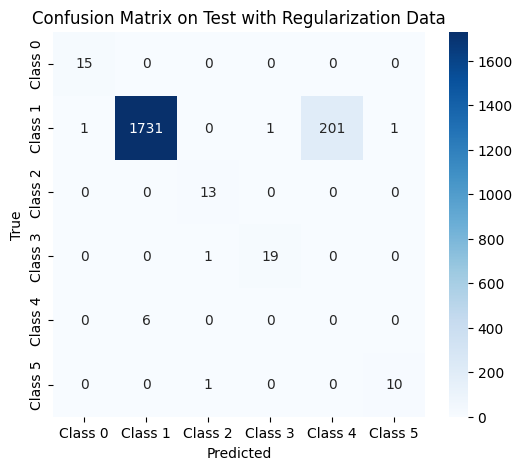

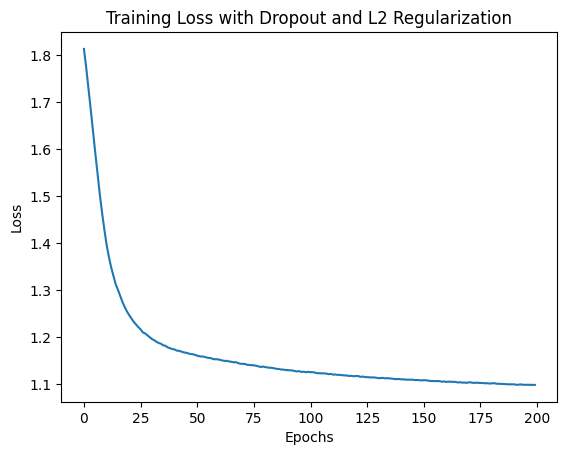

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

# Define a new model with Dropout and L2 Regularization (Weight Decay)
class ModelWithRegularization(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout_rate=0.5):
        super(ModelWithRegularization, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)  # Apply dropout between layers
        x = self.fc2(x)
        return self.softmax(x)

# Set hyperparameters and regularization settings
learning_rate = 0.01
dropout_rate = 0.5  # Dropout rate to apply
weight_decay = 1e-4  # L2 regularization (weight decay) for the optimizer

# Initialize the model with dropout
model_with_regularization = ModelWithRegularization(input_size=X_train_tensor.shape[1], 
                                                   hidden_size=128, 
                                                   output_size=6, 
                                                   dropout_rate=dropout_rate)

# Use Adam optimizer with L2 regularization (weight decay)
optimizer_with_regularization = optim.Adam(model_with_regularization.parameters(), 
                                           lr=learning_rate, 
                                           weight_decay=weight_decay)

# Define a loss function
criterion = nn.CrossEntropyLoss()

# Training loop function with dropout and L2 regularization
def train_model_with_regularization(model, optimizer, criterion, X_train, y_train, epochs=200):
    train_losses = []
    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(X_train)
        loss = criterion(outputs, y_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        if epoch % 50 == 0:  # Print every 50 epochs
            print(f'Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}')
    
    return train_losses

# Retrain the model with dropout and L2 regularization
train_losses_regularized = train_model_with_regularization(model_with_regularization, 
                                                           optimizer_with_regularization, 
                                                           criterion, 
                                                           X_train_tensor, 
                                                           y_train_tensor, 
                                                           epochs=200)

# Evaluate the model with regularization on the test set
evaluate_model(model_with_regularization, X_test_tensor, y_test_tensor, data_name="Test with Regularization")

# Visualize the training loss curve
plt.plot(train_losses_regularized)
plt.title('Training Loss with Dropout and L2 Regularization')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Compare the results with the baseline model
# Here we assume the baseline model has been trained and we have its metrics (e.g., accuracy, loss)
# You can compare these values manually by looking at the printed classification reports and confusion matrices
